In [ ]:
import seaborn as sns
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,Activation
from keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score


<h2>Connecting Dataset</h2>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


<h2> Developing Datagens </h2>

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,
                                  zoom_range = 0.2, horizontal_flip = True)

train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/archive-2/train',target_size=(224, 224),
                                              class_mode='categorical', batch_size = 32, shuffle = True)

Found 2076 images belonging to 2 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/archive-2/valid',target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical', shuffle = True)

Found 531 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/archive-2/test', target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical', shuffle = False)

Found 231 images belonging to 2 classes.


<h2>Loading the saved models </h2>

In [ ]:
!unzip /content/vgg19/vgg19.zip -d /content/vgg19


Archive:  /content/vgg19/vgg19.zip
replace /content/vgg19/custom_cnn.tf/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/vgg19/custom_cnn.tf/keras_metadata.pb  
replace /content/vgg19/custom_cnn.tf/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/vgg19/custom_cnn.tf/variables/variables.data-00000-of-00001  
replace /content/vgg19/custom_cnn.tf/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/vgg19/custom_cnn.tf/variables/variables.index  
replace /content/vgg19/custom_cnn.tf/fingerprint.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: /content/vgg19/custom_cnn.tf/fingerprint.pb  
replace /content/vgg19/custom_cnn.tf/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/vgg19/custom_cnn.tf/saved_model.pb  


In [ ]:
m2 = tf.keras.models.load_model('/content/vgg19/custom_cnn.tf')

In [ ]:
y_pred = m2.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

8/8 [==============================] - 1s 104ms/step


<h2>Accuracy metrics for vgg19 </h2>

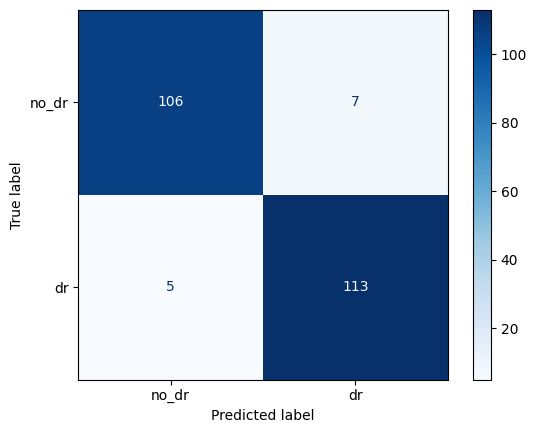

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = confusion_matrix(test_set.classes, y_pred)
labels = ["no_dr", "dr"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
plt.savefig('vgg_cm.eps', format = 'eps', dpi = 1200)
plt.savefig('vgg_cm.png', format = 'png', dpi = 1200)

In [ ]:
accuracy_score(test_set.classes, y_pred)

0.948051948051948

In [ ]:
print(classification_report(test_set.classes, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       113
           1       0.94      0.96      0.95       118

    accuracy                           0.95       231
   macro avg       0.95      0.95      0.95       231
weighted avg       0.95      0.95      0.95       231



In [ ]:
# prompt: plot roc curve given two numpy arrays
from sklearn.metrics import auc
def plot_roc_curve(tp, y_tst, pred):
  #compute roc curve and roc area for each curve
  fpr=dict()
  tpr=dict()
  roc_auc=dict()
  n_classes=2
  y_test = pd.DataFrame(pd.get_dummies(y_tst))
  predictions = pd.DataFrame(pd.get_dummies(pred))
  #loop for each class
  for i in range(n_classes):
      fpr[i],tpr[i],_=roc_curve(y_test.iloc[:,i],predictions.iloc[:,i])
      roc_auc[i]=auc(fpr[i],tpr[i])
  #micro-average roc curve
  fpr["micro"],tpr["micro"],_=roc_curve(y_test.to_numpy().ravel(),predictions.to_numpy().ravel())
  roc_auc["micro"]=auc(fpr["micro"],tpr["micro"])

  colors = ['aqua', 'darkorange']
  lw=2
  plt.figure(figsize=(12,8))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)
  labels=['No DR', 'DR']
  for i,color in zip(range(n_classes),colors):
      plt.plot(fpr[i], tpr[i], color=color,lw=lw,label='ROC curve of class {0} {name} (area = {area:0.2f})'
              ''.format(i, name=labels[i],area=roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for {} diabetic retinopathy classification'.format(tp))
  plt.legend(loc="lower right")
  plt.savefig("{}_roc.eps".format(tp),format = 'eps', dpi=1200)
  plt.savefig("{}_roc.png".format(tp),format = 'png', dpi=1200)
  plt.show()


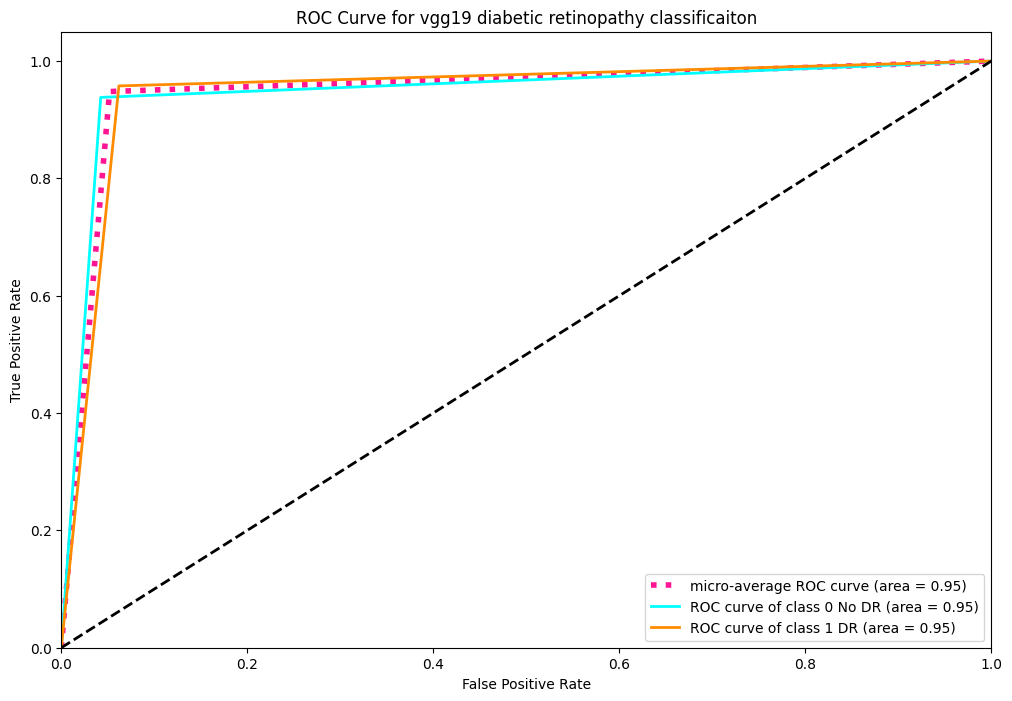

In [ ]:
plot_roc_curve('vgg19', test_set.classes, y_pred)

<h2>Accuracy metrics for VGG16</h2>

In [ ]:
!unzip /content/vgg16/vgg16.zip -d /content/vgg16

Archive:  /content/vgg16/vgg16.zip
   creating: /content/vgg16/custom_cnn.tf/
  inflating: /content/vgg16/custom_cnn.tf/keras_metadata.pb  
   creating: /content/vgg16/custom_cnn.tf/assets/
   creating: /content/vgg16/custom_cnn.tf/variables/
  inflating: /content/vgg16/custom_cnn.tf/variables/variables.data-00000-of-00001  
  inflating: /content/vgg16/custom_cnn.tf/variables/variables.index  
 extracting: /content/vgg16/custom_cnn.tf/fingerprint.pb  
  inflating: /content/vgg16/custom_cnn.tf/saved_model.pb  


In [ ]:
m2 = tf.keras.models.load_model('/content/vgg16/custom_cnn.tf')

In [ ]:
y_pred = m2.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

8/8 [==============================] - 1s 80ms/step


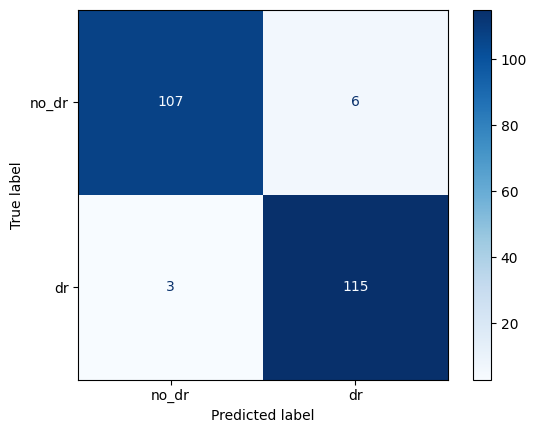

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = confusion_matrix(test_set.classes, y_pred)
labels = ["no_dr", "dr"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
plt.savefig('vgg16_cm.eps', format = 'eps', dpi = 1200)
plt.savefig('vgg16_cm.png', format = 'png', dpi = 1200)

In [ ]:
accuracy_score(test_set.classes, y_pred)

0.961038961038961

In [ ]:
print(classification_report(test_set.classes, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       113
           1       0.95      0.97      0.96       118

    accuracy                           0.96       231
   macro avg       0.96      0.96      0.96       231
weighted avg       0.96      0.96      0.96       231



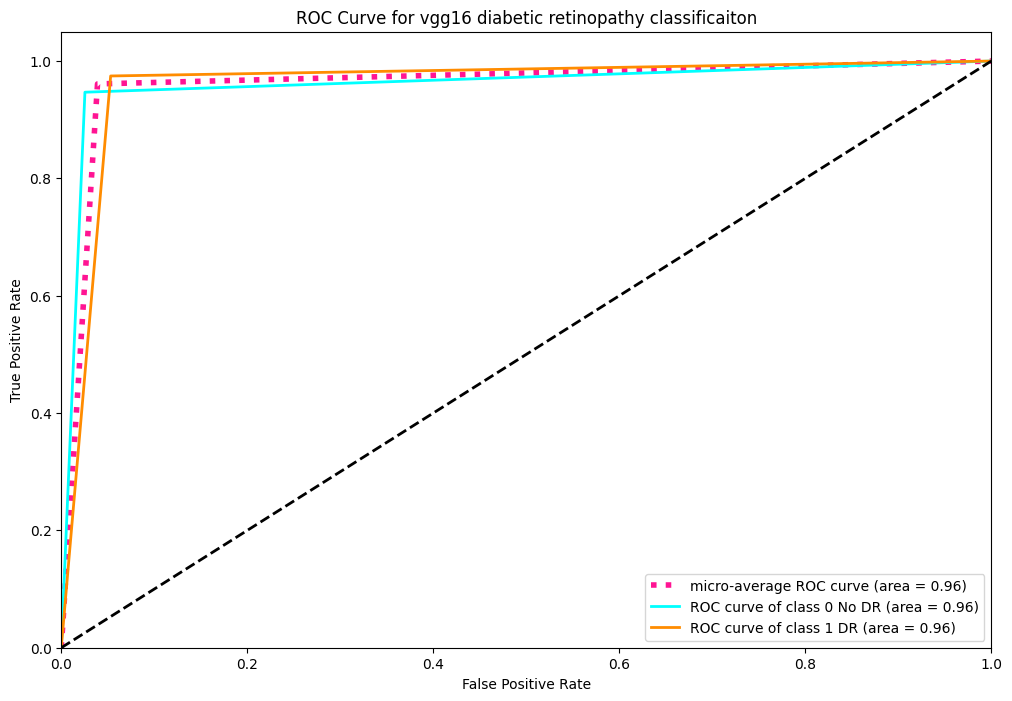

In [ ]:
plot_roc_curve('vgg16', test_set.classes, y_pred)

<h2> Accuracy metrics for inceptionv3 </h2>

In [ ]:
!unzip /content/inception_v3/inception_v3.zip -d /content/inception_v3

Archive:  /content/inception_v3/inception_v3.zip
   creating: /content/inception_v3/custom_cnn.tf/
  inflating: /content/inception_v3/custom_cnn.tf/keras_metadata.pb  
   creating: /content/inception_v3/custom_cnn.tf/assets/
   creating: /content/inception_v3/custom_cnn.tf/variables/
  inflating: /content/inception_v3/custom_cnn.tf/variables/variables.data-00000-of-00001  
  inflating: /content/inception_v3/custom_cnn.tf/variables/variables.index  
 extracting: /content/inception_v3/custom_cnn.tf/fingerprint.pb  
  inflating: /content/inception_v3/custom_cnn.tf/saved_model.pb  


In [ ]:
m2 = tf.keras.models.load_model('/content/inception_v3/custom_cnn.tf')

In [ ]:
y_pred = m2.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

8/8 [==============================] - 4s 90ms/step


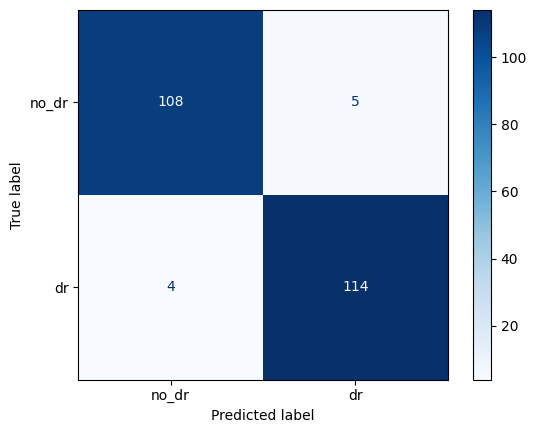

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = confusion_matrix(test_set.classes, y_pred)
labels = ["no_dr", "dr"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
plt.savefig('inception_v3_cm.eps', format = 'eps', dpi = 1200)
plt.savefig('inception_v3_cm.png', format = 'png', dpi = 1200)

In [ ]:
print(classification_report(test_set.classes, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       113
           1       0.96      0.97      0.96       118

    accuracy                           0.96       231
   macro avg       0.96      0.96      0.96       231
weighted avg       0.96      0.96      0.96       231



In [ ]:
accuracy_score(test_set.classes, y_pred)

0.961038961038961

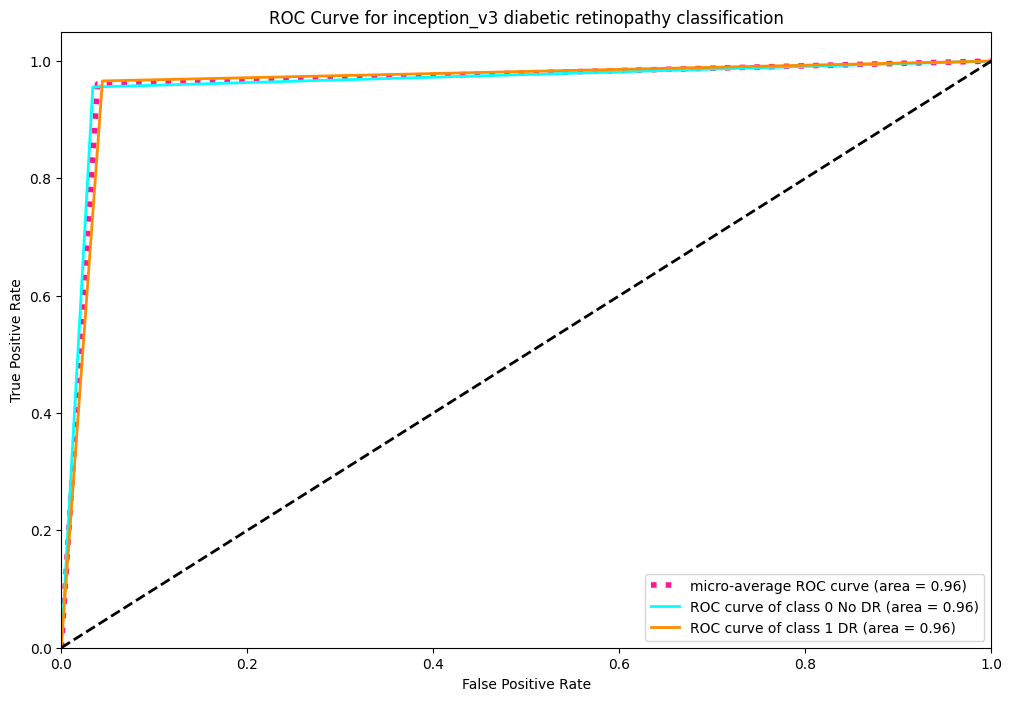

In [ ]:
plot_roc_curve('inception_v3', test_set.classes, y_pred)

<h2>MobileNetv2</h2>

In [ ]:
!unzip /content/mobile_net_v2/mobile_net_v2.zip -d /content/mobile_net_v2

Archive:  /content/mobile_net_v2/mobile_net_v2.zip
   creating: /content/mobile_net_v2/custom_cnn.tf/
  inflating: /content/mobile_net_v2/custom_cnn.tf/keras_metadata.pb  
   creating: /content/mobile_net_v2/custom_cnn.tf/assets/
   creating: /content/mobile_net_v2/custom_cnn.tf/variables/
  inflating: /content/mobile_net_v2/custom_cnn.tf/variables/variables.data-00000-of-00001  
  inflating: /content/mobile_net_v2/custom_cnn.tf/variables/variables.index  
 extracting: /content/mobile_net_v2/custom_cnn.tf/fingerprint.pb  
  inflating: /content/mobile_net_v2/custom_cnn.tf/saved_model.pb  


In [ ]:
m2 = tf.keras.models.load_model('/content/mobile_net_v2/custom_cnn.tf')

In [ ]:
y_pred = m2.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

8/8 [==============================] - 2s 85ms/step


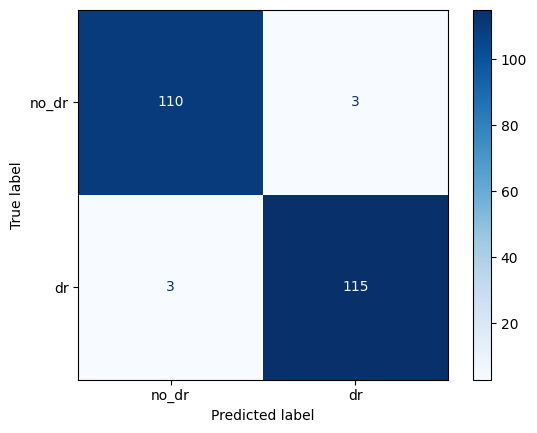

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = confusion_matrix(test_set.classes, y_pred)
labels = ["no_dr", "dr"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
plt.savefig('mobilenet_v2_cm.eps', format = 'eps', dpi = 1200)
plt.savefig('mobilenet_v2_cm.png', format = 'png', dpi = 1200)

In [ ]:
accuracy_score(test_set.classes, y_pred)

0.974025974025974

In [ ]:
print(classification_report(test_set.classes, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       113
           1       0.97      0.97      0.97       118

    accuracy                           0.97       231
   macro avg       0.97      0.97      0.97       231
weighted avg       0.97      0.97      0.97       231



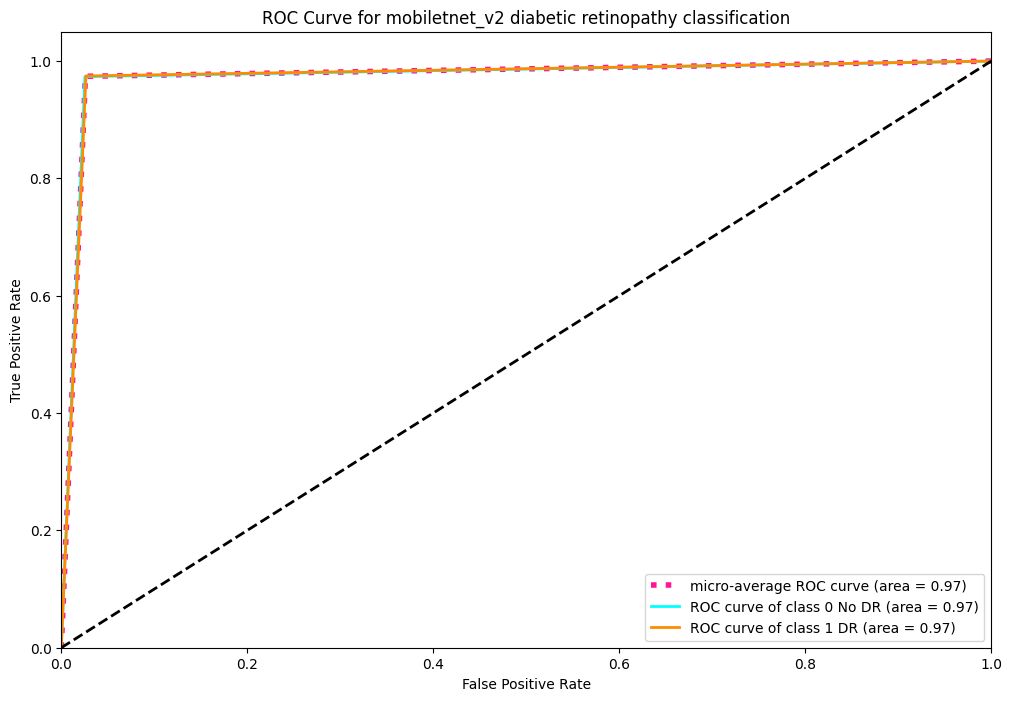

In [ ]:
plot_roc_curve('mobiletnet_v2', test_set.classes, y_pred)

<h2> Ensemble Development</h2>

In [ ]:
#loading all the models

vgg19 = tf.keras.models.load_model('/content/vgg19/custom_cnn.tf')
vgg16 = tf.keras.models.load_model('/content/vgg16/custom_cnn.tf')
inception_v3 = tf.keras.models.load_model('/content/inception_v3/custom_cnn.tf')
mobile_net_v2 = tf.keras.models.load_model('/content/mobile_net_v2/custom_cnn.tf')


In [ ]:
nets = [vgg19, vgg16, inception_v3, mobile_net_v2]

In [ ]:
#after running a grid search, best weights for classificaiton were [0, 0, 0.2, 0.4]
# we will only take inception and mobilenet for ensemble

nets = [inception_v3, mobile_net_v2]

In [ ]:
preds = np.zeros(shape=(231, 2))
weights = [0.2, 0.4]
i=0
for net in nets:
  preds += net.predict(test_set)*weights[i]
  i+=1

preds = np.argmax(preds, axis=1)
print(preds)

8/8 [==============================] - 1s 82ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


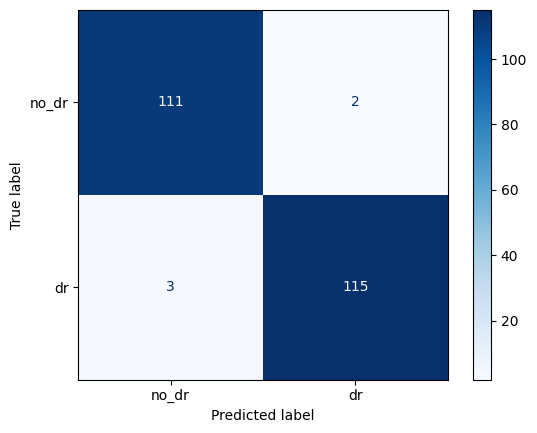

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = confusion_matrix(test_set.classes, preds)
labels = ["no_dr", "dr"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
plt.savefig('ensemble_cm.eps', format = 'eps', dpi = 1200)
plt.savefig('ensemble_cm.png', format = 'png', dpi = 1200)

In [ ]:
accuracy_score(test_set.classes, preds)

0.9783549783549783

In [ ]:
print(classification_report(test_set.classes, preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       113
           1       0.98      0.97      0.98       118

    accuracy                           0.98       231
   macro avg       0.98      0.98      0.98       231
weighted avg       0.98      0.98      0.98       231



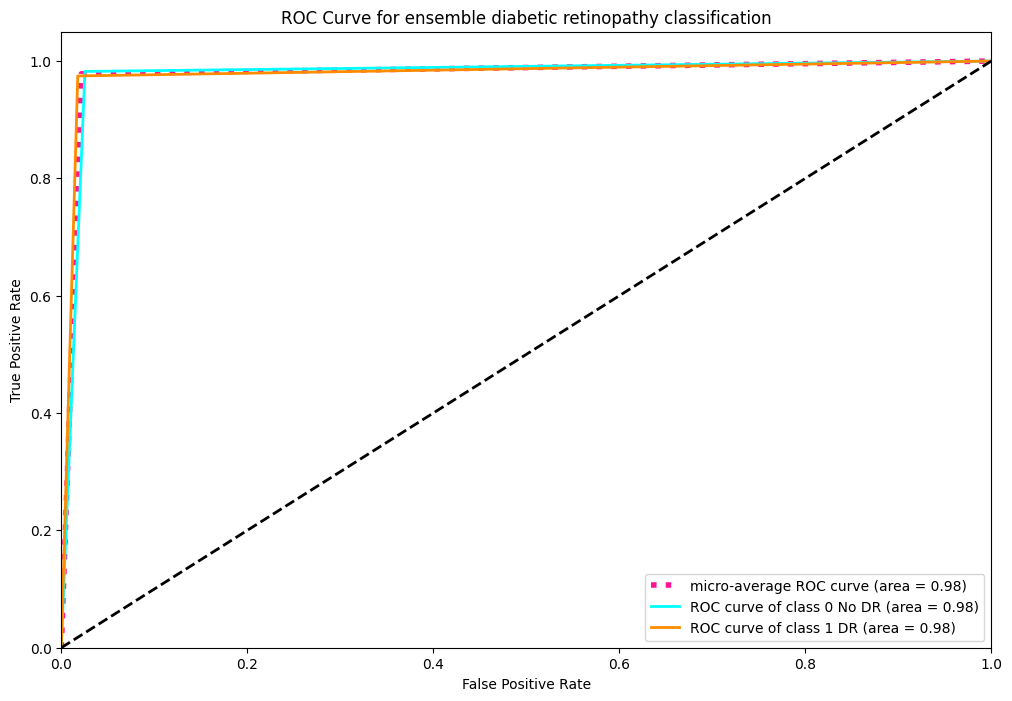

In [ ]:
plot_roc_curve('ensemble', test_set.classes, preds)